# Liner 2014

Liner, C (2014). Long-wave elastic attenuation produced by horizontal layering. _The Leading Edge_ **33** (6).

Much of the math has been coded up in [`bruges`](https://github.com/agile-geoscience/bruges). 

## Import data

In [1]:
from welly import Well

fname = './R-39.las'
well = Well.from_las(fname)

In [2]:
dtp = well.data['DT4P']
dts = well.data['DT4S']
rhob = well.data['RHOB']
z = dtp.basis

In [3]:
% matplotlib inline
import matplotlib.pyplot as plt

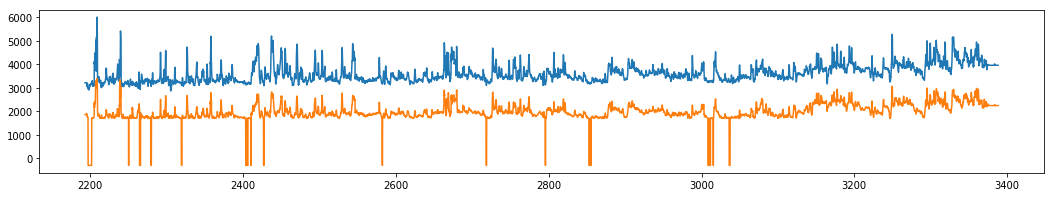

In [4]:
vp = 1e6 / dtp
vs = 1e6 / dts

plt.figure(figsize=(18,3))
plt.plot(z, vp)
plt.plot(z, vs)
plt.show()

We need to deal with these spikes.

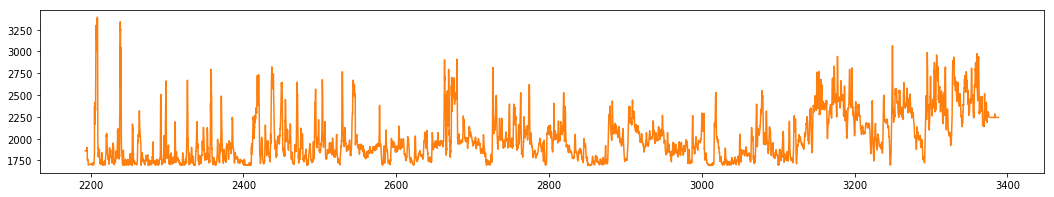

In [5]:
import numpy as np

vs_ = vs.copy()
vs_[vs_<1500] = np.nan
vs_ = vs_.interpolate()

plt.figure(figsize=(18,3))
plt.plot(z, vs_, c='C1')
plt.show()

In [6]:
vs = vs_

## Figure 1

From Liner's article in the June 2014 edition of *The Leading Edge*. See also [his blog post on the subject](http://seismosblog.blogspot.com/2014/06/backus-averaging-and-q.html), which includes some comments from Sven Treitel on the subject of negative *Q*.

In [7]:
import bruges

In [8]:
lb = 46
dz = z[1] - z[0]

vp0, vs0, rho0 = bruges.rockphysics.backus(vp, vs, rhob, lb=lb, dz=dz)

(2800, 3300)

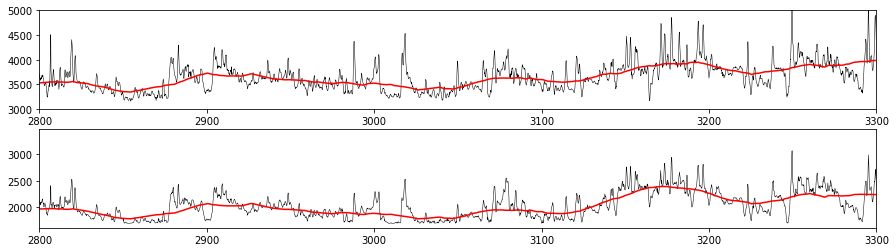

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 4))

ax = axs[0]
ax.plot(z, vp, 'k', lw=0.5)
ax.plot(z, vp0, 'r')
ax.set_xlim(2800, 3300)
ax.set_ylim(3000, 5000)

ax = axs[1]
ax.plot(z, vs, 'k', lw=0.5)
ax.plot(z, vs0, 'r')
ax.set_xlim(2800, 3300)

## Compared to V_RMS, V_AVG

In [10]:
rms = bruges.transform.v_rms(vp, depth=z)
avg = bruges.transform.v_avg(vp, depth=z)

Now we can try again to show the Backus average velocity:

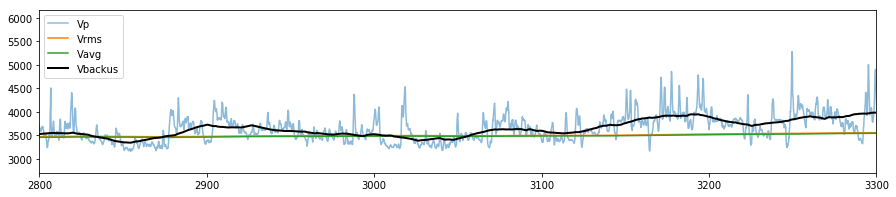

In [11]:
plt.figure(figsize=[15,3])
plt.plot(z, vp, alpha=0.5, label='Vp')
plt.plot(z, rms, label='Vrms')
plt.plot(z, avg, label='Vavg')
plt.plot(z, vp0, 'k', lw=2, label='Vbackus')
plt.xlim((2800, 3300))
plt.legend(loc='best')
plt.show()

## Figure 3

Compute *Q*p and *Q*s from Liner (2014) equation 10:

In [12]:
Qp, Qs = bruges.rockphysics.backus_quality_factor(vp, vs, rhob, lb, dz)

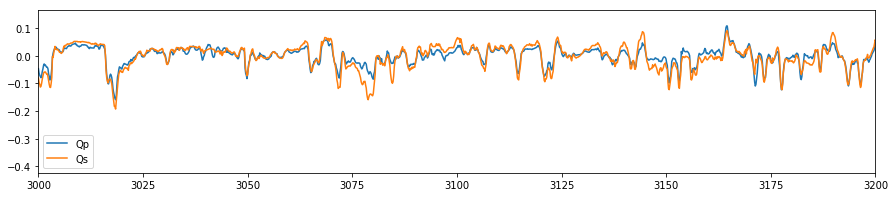

In [13]:
plt.figure(figsize=(15,3))
plt.plot(z, 1 / Qp, label='Qp')
plt.plot(z, 1 / Qs, label='Qs')
plt.xlim((3000, 3200))
plt.legend()
plt.show()

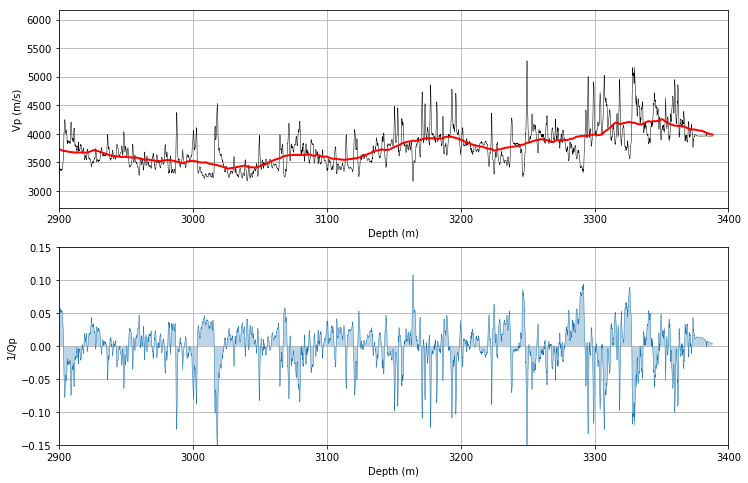

In [14]:
fig, axs = plt.subplots(nrows=2, figsize=[12,8])

ax = axs[0]
ax.plot(z, vp, 'k', lw=0.5)
ax.plot(z, vp0, 'r', lw=2)
ax.set_xlim(2900,3400) # Can also do as tuple or as kwargs
ax.grid()
ax.set_ylabel('Vp (m/s)')
ax.set_xlabel('Depth (m)')

ax = axs[1]
ax.plot(z, 1/Qp, lw=0.5)
ax.set_xlim(2900,3400)
ax.set_ylim((-0.15, 0.15))
ax.fill_between(z, 1/Qp, alpha=0.3)
ax.grid()
ax.set_ylabel('1/Qp')
ax.set_xlabel('Depth (m)')

plt.show()

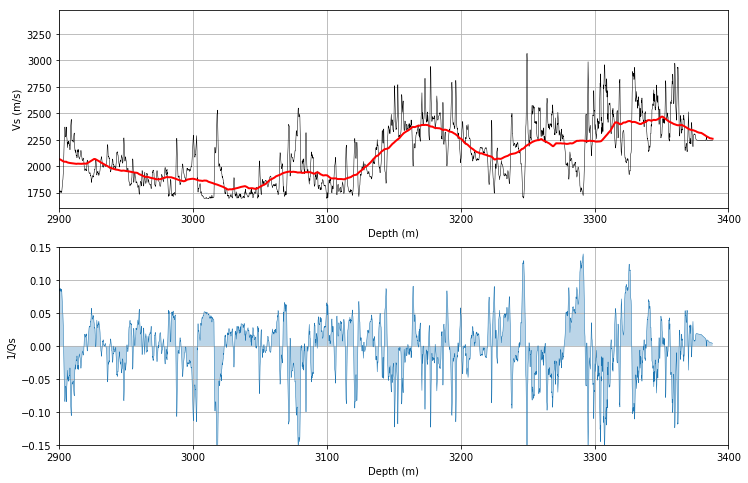

In [15]:
fig, axs = plt.subplots(nrows=2, figsize=[12,8])

ax = axs[0]
ax.plot(z, vs, 'k', lw=0.5)
ax.plot(z, vs0, 'r', lw=2)
ax.set_xlim(2900,3400) # Can also do as tuple or as kwargs
ax.grid()
ax.set_ylabel('Vs (m/s)')
ax.set_xlabel('Depth (m)')

ax = axs[1]
ax.plot(z, 1/Qs, lw=0.5)
ax.set_xlim(2900,3400)
ax.set_ylim((-0.15, 0.15))
ax.fill_between(z, 1/Qs, alpha=0.3)
ax.grid()
ax.set_ylabel('1/Qs')
ax.set_xlabel('Depth (m)')

plt.show()

## Figure 6

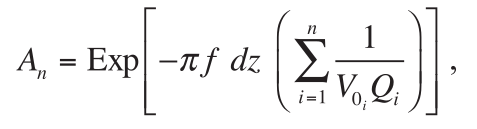

In [16]:
from IPython.display import Image
Image('equation_13.png')

So this is what I'm using:

$$ A_n = \mathrm{exp} \left[ \pi f d_z \left( \sum_{i=1}^{n} \frac{1}{V_{0, i} Q_i} \right) \right] $$

I find that using the factor of -1 inside the square brackets gives an amplified amplitude, whereas leaving it out seems to result in a curve more like Figure 13.

In [17]:
def cumulative_amplitude(f, dz, v0, q):
    s = np.cumsum(1 / (v0 * q))
    return np.exp(np.pi * f * dz * s)

In [18]:
a = cumulative_amplitude(50, dz, vp0, Qp)

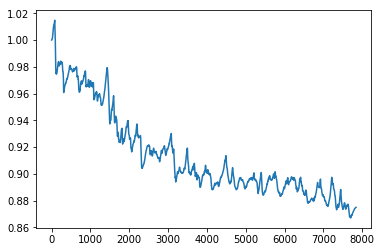

In [19]:
plt.plot(a)